In [1]:
# Importing libraries
import numpy as np 
import pandas as pd
import os

# Setting path
for dirname, _, filenames in os.walk('./archive/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./archive/translate.py
./archive/raw-img\cane\OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg
./archive/raw-img\cane\OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg
./archive/raw-img\cane\OIP---cByAiEbIxIAleGo9AqOQAAAA.jpeg
./archive/raw-img\cane\OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg
./archive/raw-img\cane\OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg
./archive/raw-img\cane\OIP---_cJbI6Ei26w5bW1urHewHaCf.jpeg
./archive/raw-img\cane\OIP--0C2kq6I68beB3DduLoxMgHaEf.jpeg
./archive/raw-img\cane\OIP--0CZnfLuBERVtzRm2QbB3gHaK4.jpeg
./archive/raw-img\cane\OIP--1QXriWyOTJg-9fEwbznmgHaI4.jpeg
./archive/raw-img\cane\OIP--2uTtzjaszBfEMCROuLN3wHaLH.jpeg
./archive/raw-img\cane\OIP--2z_zAuTMzgYM_KynUl9CQHaE7.jpeg
./archive/raw-img\cane\OIP--565fkAJy3DoFs81C9uE1QHaEY.jpeg
./archive/raw-img\cane\OIP--6mVvk2SFEi7TxqtyMbdvgHaEK.jpeg
./archive/raw-img\cane\OIP--6UY_QQC69uZF4CrwEcfUQHaHa.jpeg
./archive/raw-img\cane\OIP--7xBAVJkrjDLNCknR2fuKgHaHa.jpeg
./archive/raw-img\cane\OIP--8oCad9Nr69Ol4YEkvXJFQHaNK.jpeg
./archive/raw-img\cane\OIP--90_fw5Y28

In [2]:
# Translating animals from Spanish to English
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", 
"gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "dog": 
"cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}

In [3]:
# Importing images
import glob
Total_Images = glob.glob('./archive/raw-img/*/*.jpeg')
print("Total Number of Images:", len(Total_Images))
Total_Images = pd.Series(Total_Images)

Total Number of Images: 24209


In [5]:
# split files into 3 folders for train and test
# 80% to train 10% to val 10% to test
!pip install split-folders
import splitfolders 
train_path='./output/train/'
val_path = './output/val'
test_path='./output/test'
splitfolders.ratio('./archive/raw-img', output="output", seed=101, ratio=(.8, .1, .1))

Copying files: 26179 files [06:18, 69.25 files/s] 


In [5]:
# Reading and analyzing data
train_img_cnt = glob.glob('./output/train/*/*.jpeg')
train_img_nms = pd.Series(train_img_cnt)
train_df = pd.DataFrame()
train_df['Filename'] = train_img_nms.map( lambda img_name: img_name.split("/")[-1])
train_df['ClassId'] = train_img_nms.map(lambda img_name: img_name.split("/")[-2])
grp_cnt = train_df['ClassId'].value_counts()
grp_cnt.head(10)

cane          3890
ragno         3600
gallina       2478
cavallo       2098
mucca         1492
scoiattolo    1489
farfalla      1324
pecora        1155
gatto          984
elefante       856
Name: ClassId, dtype: int64

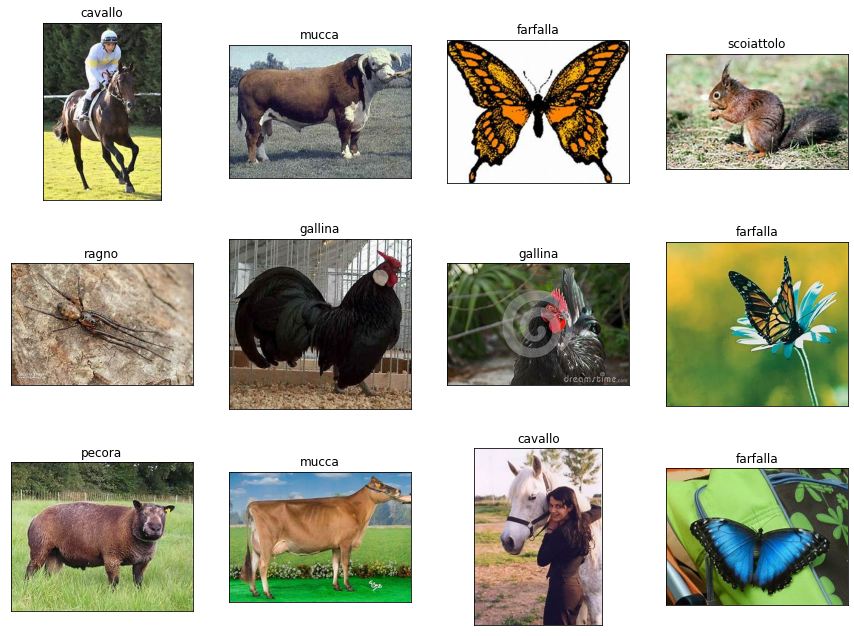

In [6]:
import matplotlib.pyplot as plt
plot_df = train_df.sample(12).reset_index()
plt.figure(figsize=(15, 15))

for i in range(12):
    img_name = plot_df.loc[i, 'Filename']
    label_str = (plot_df.loc[i, 'ClassId'])
    plt.subplot(4,4,i+1)
    plt.imshow(plt.imread(os.path.join(train_path,label_str, img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])
    plt.yticks([])

In [22]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
val_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
train_generator = train_datagen.flow_from_directory(train_path,target_size=(224, 224),batch_size=32,shuffle=True, class_mode='sparse')
test_generator = test_datagen.flow_from_directory(test_path,target_size=(224,224),batch_size=32,shuffle=False, class_mode='sparse')
val_generator = val_datagen.flow_from_directory(val_path,target_size=(224,224),batch_size=32,shuffle=False, class_mode='sparse')

Found 20938 images belonging to 10 classes.
Found 2627 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.


In [23]:
# we use ResNet50 (Deep Residual Learning for Image Recognition - https://arxiv.org/abs/1512.03385?context=cs)
# implementing this

In [24]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.initializers import glorot_uniform

def conv_block(input, f, filters, lvl, block, strides=None):
   
    conv_name_base = 'res' + str(lvl) + block + '_branch'
    bn_name_base = 'bn' + str(lvl) + block + '_branch'
    F1, F2, F3 = filters

    input_shortcut = input
   
    if strides is not None:
        model = Conv2D(filters=F1, kernel_size=(1, 1), strides=(strides, strides), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(input)
    else:
        model = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(input)
    model = BatchNormalization(axis=3, name=bn_name_base + '2a')(model)
    model = Activation('relu')(model)

    model = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(model)
    model = BatchNormalization(axis=3, name=bn_name_base + '2b')(model)
    model = Activation('relu')(model)

    model = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(model)
    model = BatchNormalization(axis=3, name=bn_name_base + '2c')(model)

    if strides is not None:
        input_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(strides, strides), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(input_shortcut)
        input_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(input_shortcut)
    
    model = Add()([model, input_shortcut])
    model = Activation('relu')(model)

    return model

In [25]:
from keras.models import Model
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = conv_block(X, f=3, filters=[64, 64, 256], lvl=2, block='a', strides=1)
    X = conv_block(X, 3, [64, 64, 256], lvl=2, block='b')
    X = conv_block(X, 3, [64, 64, 256], lvl=2, block='c')


    X = conv_block(X, f=3, filters=[128, 128, 512], lvl=3, block='a', strides=2)
    X = conv_block(X, 3, [128, 128, 512], lvl=3, block='b')
    X = conv_block(X, 3, [128, 128, 512], lvl=3, block='c')
    X = conv_block(X, 3, [128, 128, 512], lvl=3, block='d')

    X = conv_block(X, f=3, filters=[256, 256, 1024], lvl=4, block='a', strides=2)
    X = conv_block(X, 3, [256, 256, 1024], lvl=4, block='b')
    X = conv_block(X, 3, [256, 256, 1024], lvl=4, block='c')
    X = conv_block(X, 3, [256, 256, 1024], lvl=4, block='d')
    X = conv_block(X, 3, [256, 256, 1024], lvl=4, block='e')
    X = conv_block(X, 3, [256, 256, 1024], lvl=4, block='f')

    X = conv_block(X, f=3, filters=[512, 512, 2048], lvl=5, block='a', strides=2)
    X = conv_block(X, 3, [512, 512, 2048], lvl=5, block='b')
    X = conv_block(X, 3, [512, 512, 2048], lvl=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [26]:
base_model = ResNet50(input_shape=(224, 224, 3))

headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 10,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

model = Model(inputs=base_model.input, outputs=headModel)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_3 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d_3[0][0]']       
                                )                                                           

In [27]:
history = model.fit_generator(train_generator,validation_data=val_generator,epochs=10)

/var/folders/qt/0sn27c3d4yj_7315h2n5jmkr0000gn/T/ipykernel_6876/460064950.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,validation_data=val_generator,epochs=10)


Epoch 1/10


2022-08-28 18:53:01.847484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - ETA: 0s - loss: 2.4883 - accuracy: 0.2498

2022-08-28 18:58:25.611428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - 339s 506ms/step - loss: 2.4883 - accuracy: 0.2498 - val_loss: 3.4100 - val_accuracy: 0.1817
Epoch 2/10
655/655 [==============================] - 334s 509ms/step - loss: 1.7903 - accuracy: 0.3751 - val_loss: 4.0020 - val_accuracy: 0.1316
Epoch 3/10
655/655 [==============================] - 332s 506ms/step - loss: 1.5895 - accuracy: 0.4453 - val_loss: 2.9143 - val_accuracy: 0.1963
Epoch 4/10
655/655 [==============================] - 328s 501ms/step - loss: 1.4444 - accuracy: 0.5000 - val_loss: 1.5137 - val_accuracy: 0.4885
Epoch 5/10
655/655 [==============================] - 331s 505ms/step - loss: 1.3479 - accuracy: 0.5346 - val_loss: 1.2324 - val_accuracy: 0.5784
Epoch 6/10
655/655 [==============================] - 331s 504ms/step - loss: 1.2694 - accuracy: 0.5582 - val_loss: 3.4162 - val_accuracy: 0.4002
Epoch 7/10
655/655 [==============================] - 331s 505ms/step - loss: 1.2159 - accuracy: 0.5849 - val_loss: 3.5191 - val_accura

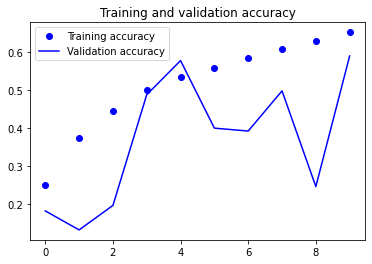

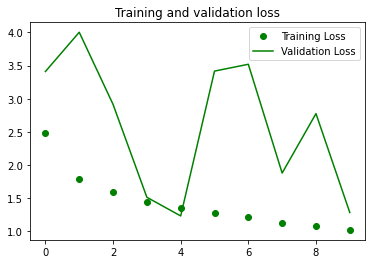

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
 test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
 print('Loss: %.3f' % (test_loss * 100.0))
 print('Accuracy: %.3f' % (test_acc * 100.0))

83/83 [==============================] - 13s 152ms/step - loss: 1.2928 - accuracy: 0.5778
Loss: 129.284
Accuracy: 57.785


In [30]:
# as we can see the accuracy is not that high.
# so.
# in the next version we will use ResNet50 already provided with tensorflow which is already pre-trained
# and use transfer learning to improve the accuracy of our data

In [41]:
# import the model from TF
from tensorflow.keras.applications import ResNet50 as r50

model_tf = r50(
      input_shape = (224,224,3),
      include_top = False,
      weights = 'imagenet'
    )

In [42]:
# mark base layers as non trainable
for layers in model_tf.layers:
    layers.trainable = False

In [43]:
from keras.layers import  Dropout
y = Flatten()(model_tf.output)
y = Dropout(0.5)(y)
y = Dense(10, activation = "softmax")(y)

model_tf = Model(model_tf.input, y)
model_tf.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = "accuracy")
model_tf.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [44]:
train_datagen_tf = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
val_datagen_tf = ImageDataGenerator()
test_datagen_tf = ImageDataGenerator()
train_generator_tf = train_datagen_tf.flow_from_directory(train_path,target_size=(224, 224),batch_size=32,shuffle=True)
test_generator_tf = test_datagen_tf.flow_from_directory(test_path,target_size=(224,224),batch_size=32,shuffle=False)
val_generator_tf = val_datagen_tf.flow_from_directory(val_path,target_size=(224,224),batch_size=32,shuffle=False)


Found 20938 images belonging to 10 classes.
Found 2627 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.


In [45]:
history_tf = model_tf.fit_generator(train_generator_tf,validation_data=val_generator_tf,epochs=10,verbose=1)

/var/folders/qt/0sn27c3d4yj_7315h2n5jmkr0000gn/T/ipykernel_6876/631879006.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_tf = model_tf.fit_generator(train_generator_tf,validation_data=val_generator_tf,epochs=10,verbose=1)


Epoch 1/10


2022-08-28 20:02:44.421138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - ETA: 0s - loss: 5.6367 - accuracy: 0.8161

2022-08-28 20:04:44.509131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


655/655 [==============================] - 134s 202ms/step - loss: 5.6367 - accuracy: 0.8161 - val_loss: 4.0510 - val_accuracy: 0.9013
Epoch 2/10
655/655 [==============================] - 132s 201ms/step - loss: 5.6791 - accuracy: 0.8754 - val_loss: 3.9436 - val_accuracy: 0.9231
Epoch 3/10
655/655 [==============================] - 131s 200ms/step - loss: 5.7980 - accuracy: 0.8917 - val_loss: 4.2240 - val_accuracy: 0.9227
Epoch 4/10
655/655 [==============================] - 131s 201ms/step - loss: 5.6781 - accuracy: 0.9023 - val_loss: 5.0194 - val_accuracy: 0.9239
Epoch 5/10
655/655 [==============================] - 131s 200ms/step - loss: 5.6146 - accuracy: 0.9093 - val_loss: 5.6784 - val_accuracy: 0.9254
Epoch 6/10
655/655 [==============================] - 131s 199ms/step - loss: 5.3787 - accuracy: 0.9143 - val_loss: 5.3413 - val_accuracy: 0.9361
Epoch 7/10
655/655 [==============================] - 134s 205ms/step - loss: 5.6741 - accuracy: 0.9185 - val_loss: 6.3986 - val_accura

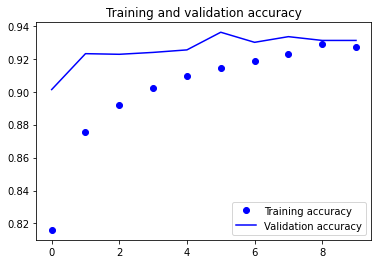

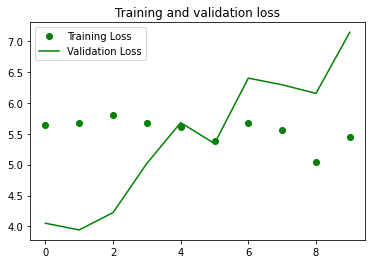

In [46]:
acc = history_tf.history['accuracy']
val_acc = history_tf.history['val_accuracy']
loss = history_tf.history['loss']
val_loss = history_tf.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [49]:
 test_loss, test_acc = model_tf.evaluate(test_generator_tf, steps=len(test_generator_tf), verbose=1)
 print('Loss: %.3f' % (test_loss * 100.0))
 print('Accuracy: %.3f' % (test_acc * 100.0))

83/83 [==============================] - 13s 150ms/step - loss: 7.2783 - accuracy: 0.9349
Loss: 727.834
Accuracy: 93.491
